In [1]:
import random
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import utils

Set training parameters

In [2]:
num_epochs = 25
batch_size = 16
learning_rate = 0.0002

random.seed(11)
torch.manual_seed(11)

# QuantGAN

### Deep Generation of Financial Time Series

reference: https://arxiv.org/pdf/1907.06673.pdf

Modeling financial time series by stochastic processes is a challenging task and a central area of research in financial mathematics. 

Quant GANs consist of a generator and discriminator function, which utilize temporal convolutional networks (TCNs) and thereby achieve to capture long-range dependencies such as the presence of volatility clusters.

### Data used

I tried to download more data using yfinance data, but the data was loading so slowly that I had to look for other datasets. In this notebook I will use a kaggle dataset:

https://www.kaggle.com/datasets/camnugent/sandp500

This dataset contains both individual stocks (for each company) and stocks of all companies alltogether for 5 years (from feb 2013 to feb 2018). 

I will use GOOGL_data.csv file to train a QuantGAN in the next sections. Let's first load it and look at the data.

In [3]:
data = pd.read_csv('./archive/individual_stocks_5yr/individual_stocks_5yr/GOOGL_data.csv')

In [4]:
data

,date,open,high,low,close,volume,Name
0,2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
1,2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2,2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
3,2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
4,2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL
...,...,...,...,...,...,...,...
1254,2018-02-01,1175.9900,1187.4500,1169.3600,1181.5900,3675709,GOOGL
1255,2018-02-02,1127.4200,1131.3000,1111.1700,1119.2000,5892122,GOOGL
1256,2018-02-05,1100.6100,1114.9900,1056.7400,1062.3900,4177469,GOOGL
1257,2018-02-06,1033.9800,1087.3800,1030.0100,1084.4300,3831524,GOOGL


The description of columns:

**date** - in format: yy-mm-dd;

**open** - price of the stock at market open (all in USD);

**high** - highest price reached in the day;

**low** - lowest price reached in the day;

**close** - price of the stock at market close (all in USD);

**volume** - number of shares traded;

**name** - the stock's ticker name.

In [5]:
data.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,682.357041,687.362776,676.691790,682.233847,2.457501e+06
std,187.409986,188.531563,186.265742,187.573892,1.591432e+06
min,384.964600,390.164800,381.010700,383.340000,5.211410e+05
25%,543.660000,547.585000,539.200000,543.022500,1.456867e+06
50%,651.570000,658.255500,642.165000,652.470000,1.938260e+06
75%,805.960000,810.739500,801.565000,806.400000,3.031624e+06
max,1188.000000,1198.000000,1184.060000,1187.560000,2.314537e+07


In [6]:
data.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

We see that there is no missing data. 

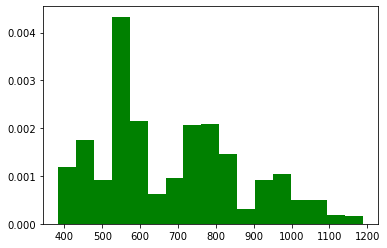

In [7]:
plt.hist(data['close'], bins='auto', density=True, color='green')
plt.show()

### Preprocess data

First we calculate the log return series

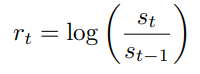

In [8]:
data_t_1 = data['close'].shift(1)
data_log = np.array(np.log(data['close'] / data_t_1)[1:])

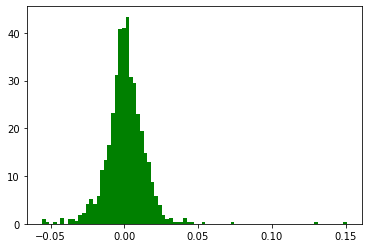

In [9]:
plt.hist(data_log, bins='auto', density=True, color='green')
plt.show()

Then we shift data to have zero mean

In [10]:
data_log_shifted = data_log - np.mean(data_log)

Inverse Lambert W transform

In [11]:
params = utils.igmm(data_log_shifted)
#gaussianize data by estimating a inverted Lambert W X F transform
data_processed = utils.W_delta((data_log_shifted - params[0]) / params[1], params[2])
data_max = np.max(np.abs(data_processed))
data_processed /= data_max

Normalize data

In [12]:
data_processed_norm = (data_processed - data_processed.mean()) / data_processed.std()
series_length = 127

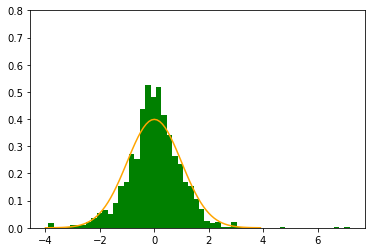

In [13]:
import math
plt.hist(data_processed_norm, bins='auto', density=True, color='green')
x_axis = np.arange(-4, 4, 0.1)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1), color='orange')
plt.ylim([0, 0.8])
plt.show()

### QuantGAN implementation

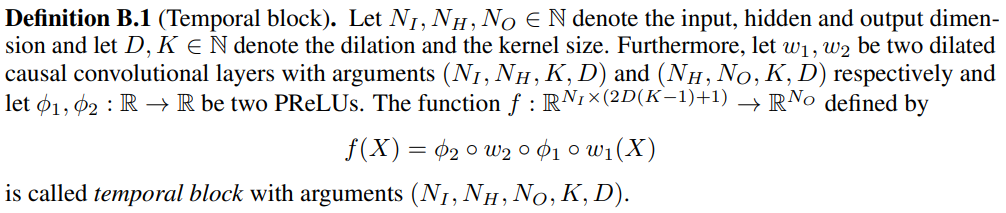

In [14]:
class TempBlock(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, kernel_size, dilation):
        super(TempBlock, self).__init__()
        self.reshape = nn.Conv1d(n_input, n_output, 1) if n_input != n_output else None
            
        # first conv + relu
        self.conv1 = nn.Conv1d(n_input, n_hidden, kernel_size, dilation=dilation, padding='same')
        self.relu1 = nn.PReLU()
        
        # second conv + relu
        self.conv2 = nn.Conv1d(n_hidden, n_output, kernel_size, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.temp = nn.Sequential(self.conv1, 
                                 self.relu1, 
                                 self.conv2, 
                                 self.relu2)

    def forward(self, x):
        output = self.temp(x)
        res = x if self.reshape is None else self.reshape(x)
        return output + res

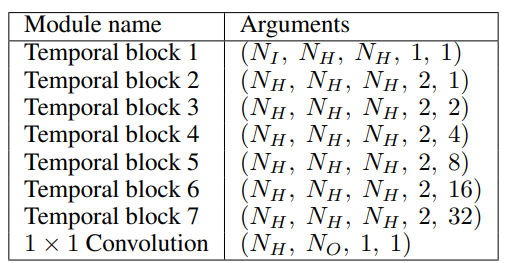

In [15]:
class TCN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(TCN, self).__init__()
        
        self.tb1 = TempBlock(n_input, n_hidden, n_hidden, 1, 1)
        self.tb2 = TempBlock(n_hidden, n_hidden, n_hidden, 2, 1)
        self.tb3 = TempBlock(n_hidden, n_hidden, n_hidden, 2, 2)
        self.tb4 = TempBlock(n_hidden, n_hidden, n_hidden, 2, 4)
        self.tb5 = TempBlock(n_hidden, n_hidden, n_hidden, 2, 8)
        self.tb6 = TempBlock(n_hidden, n_hidden, n_hidden, 2, 16)
        self.tb7 = TempBlock(n_hidden, n_hidden, n_hidden, 2, 32)
        self.conv = nn.Conv1d(n_hidden, n_output, 1)
        
        self.tcn = nn.Sequential(self.tb1,
                                 self.tb2,
                                 self.tb3,
                                 self.tb4,
                                 self.tb5,
                                 self.tb6,
                                 self.tb7
                                )

    def forward(self, x):
        y1 = self.tcn(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

Define generator and discriminator

In [16]:
class Generator(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(Generator, self).__init__()
        self.gen = TCN(n_input, n_output, n_hidden)

    def forward(self, x):
        output = self.gen(x)
        output = torch.tanh(output)
        return output

class Discriminator(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(Discriminator, self).__init__()
        self.disc = TCN(n_input, n_output, n_hidden)

    def forward(self, x):
        output = self.disc(x)
        output = torch.sigmoid(output)
        return output

### Train QuantGAN with TCN configuration

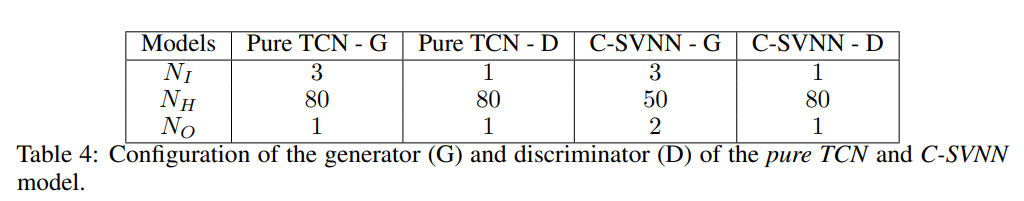

The authors of the article say that in their experiments, TCN performed better than C-SVNN, so we will focus on TCN.

We will use a pure TCN configuration, then the parameters for generator and discriminator will be:

generator: n_input = 3, n_hidden = 80, n_output = 1

discriminator: n_input = 1, n_hidden = 80, n_output = 1

In [17]:
gen_inp = 3
gen_hid = 80
gen_out = 1
disc_inp = 1
disc_hid = 80
disc_out = 1

In [18]:
generator = Generator(gen_inp, gen_out, gen_hid)
discriminator = Discriminator(disc_inp, disc_out, disc_hid)

discriminator_optim = optim.RMSprop(discriminator.parameters(), lr=learning_rate)
generator_optim = optim.RMSprop(generator.parameters(), lr=learning_rate)

dataset = utils.CreateDataset(data_processed, series_length)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Now we can train the model

In [19]:
for epoch in tqdm(range(num_epochs)):
    for index, batch in enumerate(dataloader):
        discriminator.zero_grad()
        batch_size, seq_len = batch.size(0), batch.size(1)
        noise = torch.randn(batch_size, series_length, gen_inp)
        disc_fake = generator(noise).detach()

        discriminator_loss = -torch.mean(discriminator(batch)) + torch.mean(discriminator(disc_fake))
        discriminator_loss.backward()
        discriminator_optim.step()

        # clip discriminator weights between -0.01, 0.01
        for param in discriminator.parameters():
            param.data.clamp_(-0.01, 0.01)
  
        if index % 16 == 0:
            generator.zero_grad()
            generator_loss = -torch.mean(discriminator(generator(noise)))
            generator_loss.backward()
            generator_optim.step()  

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\poder\anaconda3\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:34<00:00, 13.37s/it]


Saving model

In [20]:
model_scripted = torch.jit.script(generator) # Export to TorchScript
model_scripted.save('generator.pt') # Save

In [21]:
model_scripted = torch.jit.script(discriminator) # Export to TorchScript
model_scripted.save('discriminator.pt') # Save

### Visualization

Let's repeat the plots of a paper

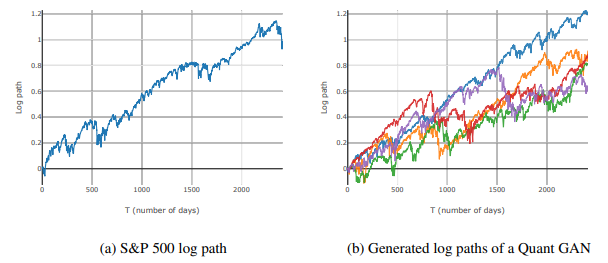

In [22]:
data_len = len(data)
data_len

1259

In [23]:
def generate_fakes(n=1, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, data_len - 1, gen_inp)
        fake = generator(noise).detach().cpu().reshape(data_len - 1).numpy()
        data_fake = utils.inverse(fake * data_max, params) + data_log.mean()
        fakes.append(data_fake)
    if n > 1:
        if not cumsum:
            return pd.DataFrame(fakes).T
        fakes_df = pd.DataFrame(fakes).T.cumsum()
        return fakes_df
    elif not cumsum:
        return data_fake
    return data_fake.cumsum()

Text(0.5, 1.0, 'Generated log paths')

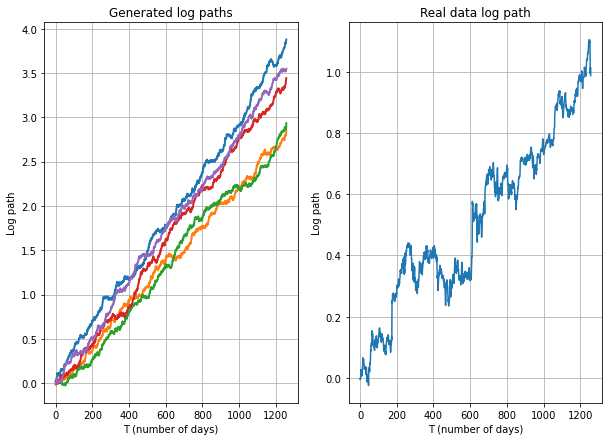

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.plot(generate_fakes(5), linewidth=2)
ax2.plot(data_log.cumsum())
ax1.grid(True)
ax2.grid(True)
ax1.set_xlabel('T (number of days)')
ax2.set_xlabel('T (number of days)')
ax1.set_ylabel('Log path')
ax2.set_ylabel('Log path')
ax2.set_title('Real data log path')
ax1.set_title('Generated log paths')

We see some variability in the generated paths, although they simplify the historical picture. This may be due to insufficient training data: we used 5 years of data from one company, but it might have been better to take a longer time period (as I said before, it was hard to get more data, that's why I used only 5 years).

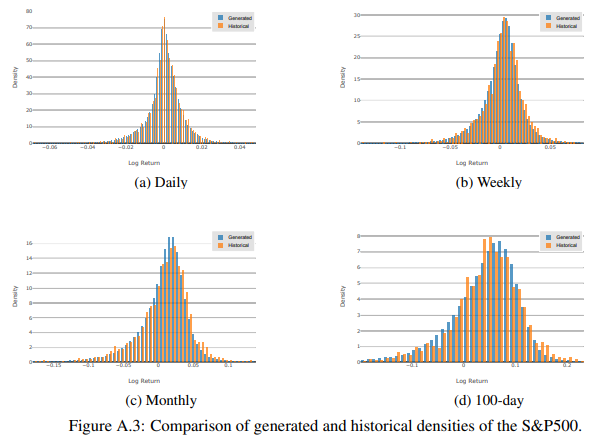

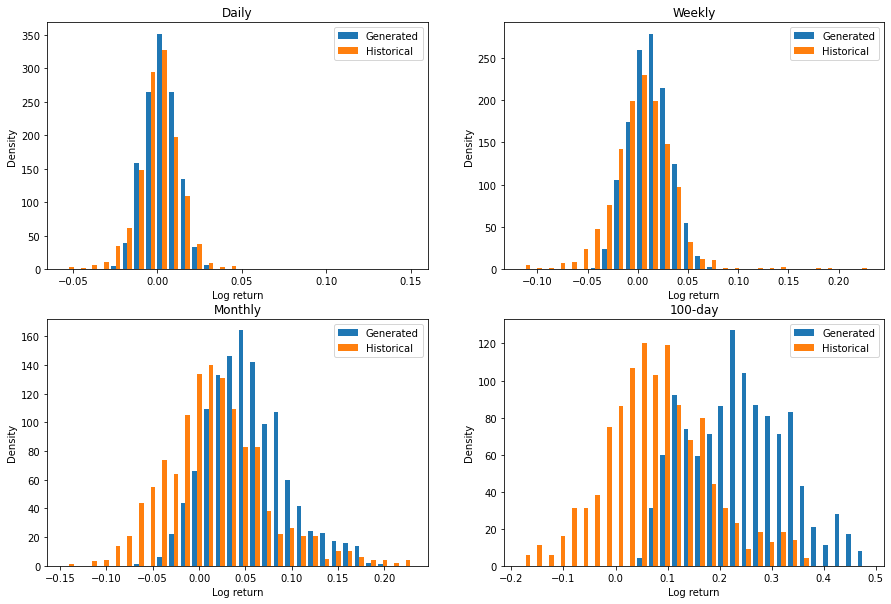

In [25]:
fig, ([ax1, ax2,],[ ax3, ax4]) = plt.subplots(2, 2, figsize=(15, 10))
#daily
ax1.hist([pd.Series(generate_fakes()).diff(), 
          pd.Series(data_log.cumsum()).diff()], 
         bins=30, label=['Generated', 'Historical'])
ax1.legend(loc='upper right')
ax1.set_xlabel('Log return')
ax1.set_ylabel('Density')
ax1.set_title('Daily')
#weekly
ax2.hist([pd.Series(generate_fakes()).diff(5), 
          pd.Series(data_log.cumsum()).diff(5)], 
         bins=30, label=['Generated', 'Historical'])
ax2.legend(loc='upper right')
ax2.set_xlabel('Log return')
ax2.set_ylabel('Density')
ax2.set_title('Weekly')
#monthly
ax3.hist([pd.Series(generate_fakes()).diff(20), 
          pd.Series(data_log.cumsum()).diff(20)], 
         bins=30, label=['Generated', 'Historical'])
ax3.legend(loc='upper right')
ax3.set_xlabel('Log return')
ax3.set_ylabel('Density')
ax3.set_title('Monthly')
#100-days
ax4.hist([pd.Series(generate_fakes()).diff(100), 
          pd.Series(data_log.cumsum()).diff(100)], 
         bins=30, label=['Generated', 'Historical'])
ax4.legend(loc='upper right')
ax4.set_xlabel('Log return')
ax4.set_ylabel('Density')
ax4.set_title('100-day')
plt.show()

Here we see that as the time period increases, the shift between the historical and generated data become more visible. But for the 'daily' and 'weekly' graphs they seems to be pretty close, while 'monthly' and '100-day' shows that generated data is shifted to the left.

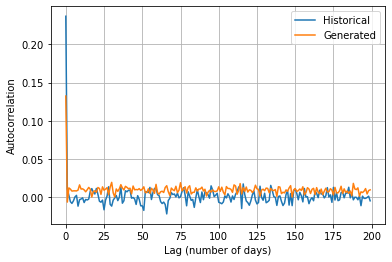

In [26]:
plt.plot(utils.autocorrelation(data_log, 200), label='Historical')
plt.plot(utils.autocorrelation(generate_fakes(cumsum=False), 200), label='Generated')
plt.legend()
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (number of days)')
plt.grid(True)
plt.show()

It seems that we should try to use more data to get more accurate results. 